<a href="https://www.kaggle.com/code/subhadipde2000/sentiment-classifier-with-fnet?scriptVersionId=196190065" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction

In the realm of e-commerce, customer reviews play a pivotal role in shaping consumer behavior and influencing purchasing decisions. Amazon, as one of the largest online retail platforms, hosts a vast repository of product reviews that provide valuable insights into customer sentiment. The ability to classify these reviews as positive or negative is crucial for both businesses and consumers, enabling better product evaluation and strategic decision-making.

This project aims to leverage Natural Language Processing (NLP) techniques to classify Amazon product reviews into positive and negative sentiments. We will fine-tune the FNet model from KerasNLP, a state-of-the-art transformer-based model, to achieve this classification. The dataset comprises 3.6 million training instances and 400,000 test instances, offering a robust foundation for model training and evaluation.

Through this project, we will explore various stages of the NLP pipeline, including data cleaning, preprocessing, feature engineering, and model fine-tuning. Additionally, we will employ data visualizations to gain insights into the length of reviews and the distribution of sentiments. The ultimate goal is to develop an accurate and efficient sentiment classification model that can be deployed in real-world applications.

---

# Problem Statement

The primary objective of this project is to develop a sentiment classification model for Amazon product reviews. Specifically, we aim to classify reviews into two categories: positive and negative. The dataset consists of 3.6 million training reviews and 300,000 test reviews, providing a comprehensive basis for model development and evaluation.

To achieve this, we will fine-tune the FNet model from KerasNLP, a transformer-based architecture known for its efficiency and performance in NLP tasks. The project will involve several key steps, including:

1. **Data Cleaning and Preprocessing**: Ensuring the data is free from noise and is in the correct format for modelling.
2. **Feature Engineering**: Merging review titles and texts to create a unified input for the model.
3. **Data Visualization**: Analyzing the length of reviews and the distribution of sentiments to gain insights into the dataset.
4. **Model Fine-Tuning**: Adapting the FNet model to the specific task of sentiment classification.
5. **Evaluation**: Assessing the model's performance on the test dataset to ensure its accuracy and reliability.

By successfully completing these steps, we aim to create a robust sentiment classification model that can accurately categorize Amazon product reviews, thereby enhancing the utility of review data for both businesses and consumers.

---

In [1]:
!nvidia-smi

Wed Sep 11 10:51:32 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P0             28W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Imports

In [2]:
import os
os.environ["KERAS_BACKEND"] = "jax"

import keras
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras_nlp.models import FNetPreprocessor, FNetClassifier

2024-09-11 10:51:38.707747: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-11 10:51:38.707895: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-11 10:51:38.846271: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
warnings.filterwarnings("ignore")

In [4]:
# Reproducability
tf.keras.utils.set_random_seed(291)

# Mixed Precision

Mixed precision is a technique used in deep learning to improve the performance and efficiency of model training by utilizing a combination of different data types, primarily ```float16``` and ```float32```. This approach allows for faster computations and reduced memory usage without significantly compromising the model's accuracy.

In [5]:
keras.mixed_precision.set_global_policy("mixed_float16")

# Getting the filepaths

In [6]:
for root, dirs, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        if filename.endswith('train.csv'):
            train_dir = os.path.join(root, filename)
        elif filename.endswith('test.csv'):
            test_dir = os.path.join(root, filename)

print(f"Path to train dataset = {train_dir}\nPath to test dataset = {test_dir}")

Path to train dataset = /kaggle/input/amazon-reviews/train.csv
Path to test dataset = /kaggle/input/amazon-reviews/test.csv


# Reading the datasets

In [7]:
def read_dataset(path_to_dataset):
    """
    This function will read in a dataset from a specified path, concatenate the header row into the
    dataset and rename the columns of the dataset.
    Args:
        path_to_dataset = Path to the dataset in the form of a string
    """
    
    dataset = pd.read_csv(path_to_dataset)
    
    # Concatenate the dataset headers as a row to the dataset
    columns = ['Sentiment', 'Title', 'Review']
    if list(dataset.columns) != columns:
        dataset.columns = columns
    
    # Change the data type of the columns
    dataset.Sentiment = dataset.Sentiment.astype(int)
    dataset.Title = dataset.Title.astype(str)
    dataset.Review = dataset.Review.astype(str)
    
    return (dataset)

In [8]:
train_df = read_dataset(train_dir)
train_df.head()

,Sentiment,Title,Review
0,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
1,2,Amazing!,This soundtrack is my favorite music of all ti...
2,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
3,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
4,2,an absolute masterpiece,I am quite sure any of you actually taking the...


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3599999 entries, 0 to 3599998
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   Sentiment  int64 
 1   Title      object
 2   Review     object
dtypes: int64(1), object(2)
memory usage: 82.4+ MB


In [10]:
test_df = read_dataset(test_dir)
test_df.head()

,Sentiment,Title,Review
0,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
1,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
2,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
3,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...
4,1,DVD Player crapped out after one year,I also began having the incorrect disc problem...


In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399999 entries, 0 to 399998
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Sentiment  399999 non-null  int64 
 1   Title      399999 non-null  object
 2   Review     399999 non-null  object
dtypes: int64(1), object(2)
memory usage: 9.2+ MB


# Data cleaning

In [12]:
# Dropping duplicate rows from the dataframe, if any
num_dup = train_df.duplicated().sum()
if num_dup > 0:
    train_df.drop_duplicates(inplace=True)
    print(f"Dropped {num_dup} dupliacte rows from the dataframe.")
    print(f'Now the dataframe has {len(train_df)} rows.')
else:
    print(f"There are {num_dup} duplicate rows in the dataframe.")

There are 0 duplicate rows in the dataframe.


In [13]:
def review_lengths(col):
    '''
    This function will print the average length, the maximum length, and the minimum length of the texts in a column in terms
    of the number of words, when called.
    '''
    
    max_len, min_len, total_len = 0, 99999999999999, 0

    train_df[col] = train_df[col].astype(str)

    for text in train_df[col].tolist():
        if text != None:
            total_len += len(text.split())
            if len(text.split()) > max_len:
                max_len = len(text.split())
            if len(text.split()) < min_len:
                min_len = len(text.split())

    avg_len = round(total_len/len(train_df))
    print(f"The longest {col} has {max_len} words, the shortest {col} has {min_len} words, and the average {col} length is {avg_len} words.")

In [14]:
review_lengths('Title')

The longest Title has 39 words, the shortest Title has 1 words, and the average Title length is 4 words.


In [15]:
# Checking the elements of the 'Title' column which has only 1 word
train_df[train_df['Title'].apply(lambda x: len(x.split()) == 1)]['Title']

1               Amazing!
26          Disappointed
43                autumn
58         Disappointing
68              Rapunzel
               ...      
3599947       Leprechaun
3599953       AMazing...
3599959        Impressed
3599960             Dull
3599991          AWESOME
Name: Title, Length: 339986, dtype: object

* We can see that the titles with which has only word are actutal words and not some gibberish.

In [16]:
review_lengths('Review')

The longest Review has 254 words, the shortest Review has 1 words, and the average Review length is 74 words.


In [17]:
# Checking the elements of the 'Review' column which has only 1 word
train_df[train_df['Review'].apply(lambda x: len(x.split()) == 1)]['Review']

567146     TeTerriffic!Terriffic!Terriffic!Terriffic!Terr...
589387                                                  drek
629877                       ...............................
759193     Thisis.the.very.first.book.by.her.that.I.had.a...
817507     gogogogagagagagagamandiffheuejkuawieuajdsifjhj...
1059215                                              goooood
1373976    booooooooooooooooooooooooooooooooooooooooooooo...
1714158    JUNK!!SUCKS!TURD!!JUSTREADTHEREVIEWSOFTHEPEOPL...
1997409    WellIboughtanddroppeditalotanditheldupbutitbro...
2014966    hahahahahaha..............hahahahahahaha.........
2156788    BRILLIANT!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...
2338470                                               Great.
2357002    http://www.strangeland.com/asp/show.asp?id=136...
2553935    AmusingBrilliantCleverDelightfulEndearingFunGr...
2712774                                 Great...Reccommended
3392963                                                 Good
3487489    )()()()()()!@

* We can see that the reviews with only one word are nothing but gibberish. 
* So, we will first grab the indices of those rows, and then drop them.

In [18]:
a = len(train_df)
index_list = train_df[train_df['Review'].apply(lambda x: len(x.split()) == 1)].index.tolist()
train_df = train_df.drop(index_list)
b = len(train_df)
print(f"Dropped {a-b} rows from train_df.")

Dropped 17 rows from train_df.


# Data Visualizations

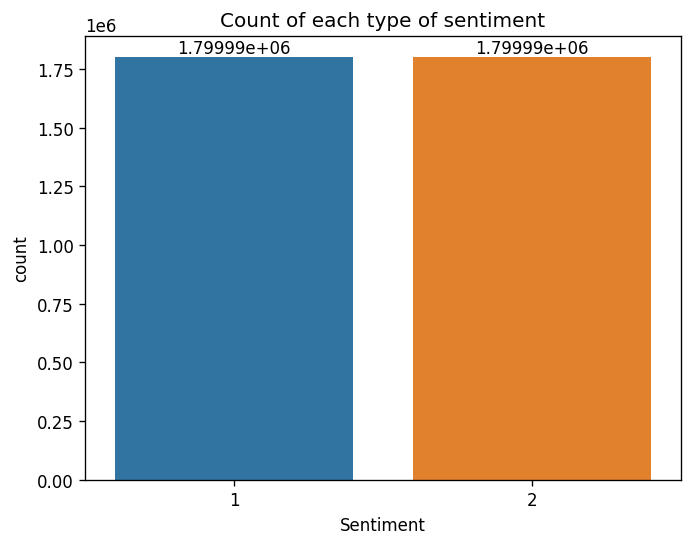

In [19]:
plt.figure(dpi=120)
plt.title("Count of each type of sentiment")
ax = sns.countplot(data=train_df, x='Sentiment')
ax.bar_label(ax.containers[0], fontsize=10);

* We can see that we have a balanced dataset as we have equal numbers of positive and negative reviews

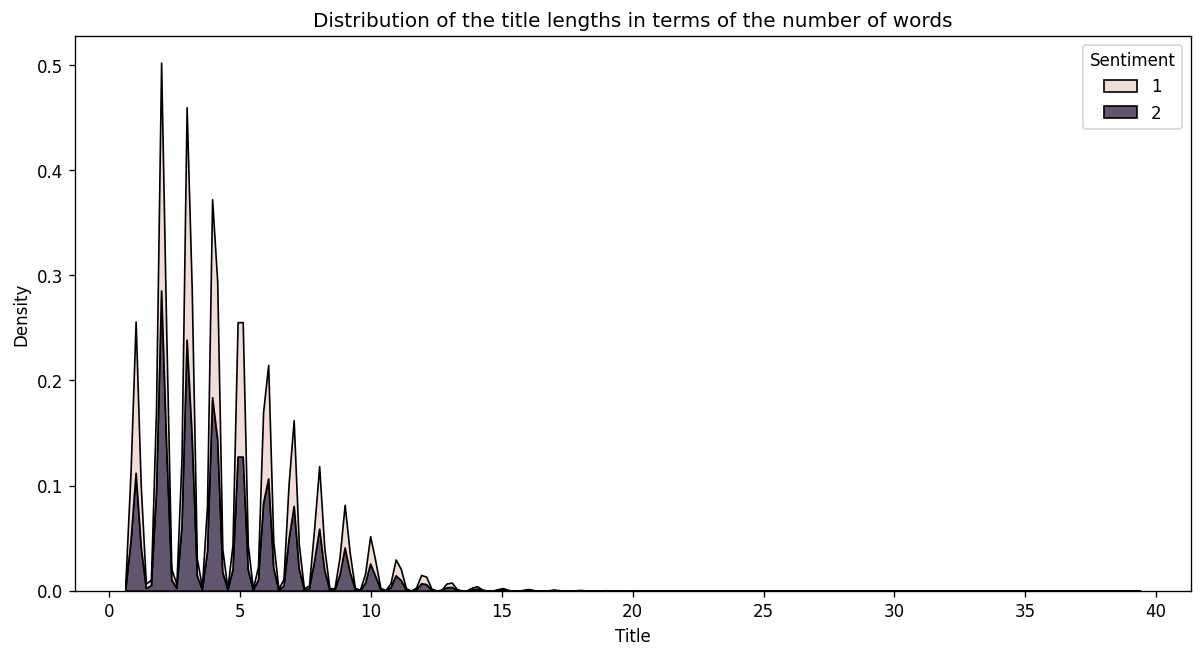

In [20]:
plt.figure(figsize=(12, 6), dpi=120)
plt.title('Distribution of the title lengths in terms of the number of words')
sns.kdeplot(data=train_df, x=train_df['Title'].str.split().apply(len), hue='Sentiment', multiple='stack');

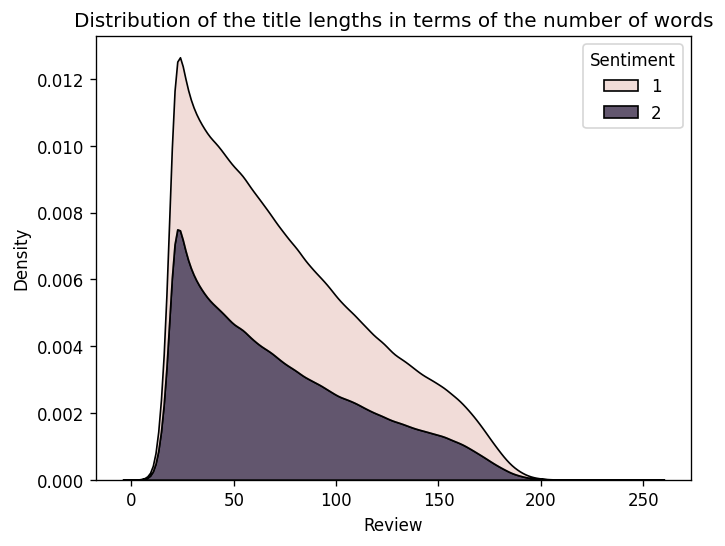

In [21]:
plt.figure(dpi=120)
plt.title('Distribution of the title lengths in terms of the number of words')
sns.kdeplot(data=train_df, x=train_df['Review'].str.split().apply(len), hue='Sentiment', multiple='stack');

# Feature engineering

* We will create a new column by merging together the 'Title' and the 'Review' columns.

In [22]:
def feature_engineer(dataset):
    # df = dataset.copy()
    if "Amazon Reviews" not in dataset.columns:
        dataset['Amazon Reviews'] = dataset['Title'] + ". " + dataset['Review']
        dataset.drop(['Title', 'Review'], axis=1, inplace=True)
    return dataset

In [23]:
train_df = feature_engineer(train_df)
train_df.head()

,Sentiment,Amazon Reviews
0,2,The best soundtrack ever to anything.. I'm rea...
1,2,Amazing!. This soundtrack is my favorite music...
2,2,Excellent Soundtrack. I truly like this soundt...
3,2,"Remember, Pull Your Jaw Off The Floor After He..."
4,2,an absolute masterpiece. I am quite sure any o...


In [24]:
test_df = feature_engineer(test_df)
test_df.head()

,Sentiment,Amazon Reviews
0,2,One of the best game music soundtracks - for a...
1,1,Batteries died within a year .... I bought thi...
2,2,"works fine, but Maha Energy is better. Check o..."
3,2,Great for the non-audiophile. Reviewed quite a...
4,1,DVD Player crapped out after one year. I also ...


In [25]:
review_lengths('Amazon Reviews')

The longest Amazon Reviews has 257 words, the shortest Amazon Reviews has 3 words, and the average Amazon Reviews length is 78 words.


# Splitting the data

In [26]:
X_train, X_valid, y_train, y_valid = train_test_split(
    train_df['Amazon Reviews'],
    train_df['Sentiment'],
    test_size=0.003, 
    random_state=101
)

X_test = test_df['Amazon Reviews']
y_test = test_df['Sentiment']

# Data preprocessing

In [27]:
# FNet preprocessor
preprocessor = FNetPreprocessor.from_preset(
    preset = "f_net_base_en",
    sequence_length = 78 # average length of amazon reviews
)

Attaching 'model.safetensors' from model 'keras/f_net/keras/f_net_base_en/2' to your Kaggle notebook...
Attaching 'model.safetensors.index.json' from model 'keras/f_net/keras/f_net_base_en/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/f_net/keras/f_net_base_en/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/f_net/keras/f_net_base_en/2' to your Kaggle notebook...
Attaching 'preprocessor.json' from model 'keras/f_net/keras/f_net_base_en/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/f_net/keras/f_net_base_en/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/f_net/keras/f_net_base_en/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.spm' from model 'keras/f_net/keras/f_net_base_en/2' to your Kaggle notebook...


In [28]:
# Let's have a look at how the FNet pre-processor works
x = random.randint(0, len(train_df))

text = train_df.iloc[x, 1]
processed_text = preprocessor(text)

print(f'Original text: \n{text}\n')
print(f'Processed text with DeBERTaV3 preprocessor: \n{processed_text}')

Original text: 
Disgaea - the complete series. I don't do games and I'm not familiar with the entertainment, but from somewhere, an advertisement for this series appealed to me. That in itself is unusual, because sadly, anime commercials nearly always fail to sell their product. This one looked a little quirkey, a little rude, and a bit on the fast-paced side, so I took a chance on it. I am glad I did. Disgaea is a fun series, full of demons who aren't quite as bad as they might be, angels and heros who aren't as good as they should be, and worlds we all can relate to. The story is nothing new, but the presentation is well done and the tale is a good one. If you like sarcastic comedy with anti-heros and anti-villians mixing it up for the sake of their own views and goals, Disgaea will entertain you.

Processed text with DeBERTaV3 preprocessor: 
{'token_ids': Array([    4,  2102,  4471, 16658, 16660,   435,    13,  1228,  1987,
       16678,    57,   654, 16707, 16659,   202,  2073,    

In [29]:
# Function for pre-processing text
def preprocess_fn(text, label=None):
    text = preprocessor(text)
    return (text, label) if label is not None else text

# Building tensorflow datasets

* While constructing the tensorflow datasets, we will make some changes in how we are defining the sentiments.
* The positive sentiments will now be represented as ```[1, 0]```, and the negative sentiments will be represented as ```[0, 1]```.
* This will later help us in knowing, how much does the model thinks that a review is postive or negative.

In [30]:
# Function for building tensorflow datasets
def build_tf_dataset(reviews, sentiments=None, BATCH_SIZE=32, shuffle=True):
    AUTO = tf.data.AUTOTUNE
    options = tf.data.Options()
    options.experimental_deterministic = False
    
    reviews = tf.convert_to_tensor(reviews.tolist() if not isinstance(reviews, list) else reviews)
    if sentiments is not None:
        sentiments = [[1, 0] if value == 2 else [0, 1] for value in sentiments]
        sentiments = tf.convert_to_tensor(sentiments)
        
    slices = (reviews,) if sentiments is None else (reviews, sentiments)
    
    dataset = tf.data.Dataset.from_tensor_slices(slices).cache()
    dataset = dataset.map(preprocess_fn, num_parallel_calls=AUTO)
    if shuffle:
        dataset = dataset.shuffle(1024, seed=101)
    dataset = dataset.with_options(options).batch(BATCH_SIZE).prefetch(AUTO)
    
    return dataset

* Since we have a limited capacity of compute, so to reduce the training time, we will use the first 1.8 million rows from `X_train` and `y_train` for creating our tensorflow training dataset which is approximately half the number of rows in `train_df`.

In [31]:
train_dataset = build_tf_dataset(X_train[:int(1.8e+6)], y_train[:int(1.8e+6)])
valid_dataset = build_tf_dataset(X_valid, y_valid)
test_dataset = build_tf_dataset(X_test, y_test)

# Modelling

The `f_net_base_en` model is a transformer-based model developed by Google Research as part of the FNet architecture. Unlike traditional transformer models, which rely on self-attention mechanisms, FNet uses a **Fourier Transform** to encode token interactions. This reduces the computational complexity, making it more efficient in terms of speed and memory usage while maintaining competitive performance on natural language understanding tasks. The `f_net_base_en` variant is typically pre-trained on English text, offering a balance between performance and efficiency, suitable for tasks like text classification, sentiment analysis, and question-answering.

In [32]:
classifier = FNetClassifier.from_preset(
    "f_net_base_en",
    preprocessor=None,
    activation = 'softmax',
    num_classes=2
)

Attaching 'model.safetensors' from model 'keras/f_net/keras/f_net_base_en/2' to your Kaggle notebook...
Attaching 'model.safetensors.index.json' from model 'keras/f_net/keras/f_net_base_en/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/f_net/keras/f_net_base_en/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/f_net/keras/f_net_base_en/2' to your Kaggle notebook...
Attaching 'task.json' from model 'keras/f_net/keras/f_net_base_en/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/f_net/keras/f_net_base_en/2' to your Kaggle notebook...
Attaching 'model.safetensors' from model 'keras/f_net/keras/f_net_base_en/2' to your Kaggle notebook...
Attaching 'model.safetensors.index.json' from model 'keras/f_net/keras/f_net_base_en/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/f_net/keras/f_net_base_en/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/f_net/keras/f_net_base_e

In [33]:
from keras.metrics import Precision, Recall, F1Score
classifier.compile(
    optimizer=keras.optimizers.AdamW(1e-4),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[
        'accuracy',
    ]
)

In [34]:
classifier.summary()

Model: "f_net_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ segment_ids (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ f_net_backbone (FNetBackbone) │ [(None, 768), (None,      │      82,861,056 │ segment_ids[0][0],         │
│                               │ None, 768)]               │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ f_net_backbone[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 82,862,594 (316.10 MB)

 Trainable params: 82,862,594 (316.10 MB)

 Non-trainable params: 0 (0.00 B)

# Model training

In [35]:
history = classifier.fit(
    train_dataset,
    validation_data = valid_dataset,
    epochs = 1,
)

56250/56250 ━━━━━━━━━━━━━━━━━━━━ 8449s 150ms/step - accuracy: 0.5024 - loss: 0.6940 - val_accuracy: 0.5075 - val_loss: 0.6931


# Model evaluation

In [36]:
test_loss, test_accuracy = classifier.evaluate(test_dataset)
print(f"The model loss on the test dataset is {round(test_loss, 4)}.")
print(f"The model accuracy on the test dataset is {round(test_accuracy*100, 4)}%.")

12500/12500 ━━━━━━━━━━━━━━━━━━━━ 692s 55ms/step - accuracy: 0.5039 - loss: 0.6932
The model loss on the test dataset is 0.6932.
The model accuracy on the test dataset is 49.9999%.


* We will now check the performance of our model on some sample reviews that are not there in our dataset.
* For this, we will have 5 positive reviews and 5 negative reviews.
* The sample reviews were generated using **ChatGPT**.

In [37]:
def predict_sentiments(reviews):
    if isinstance(reviews, list):
        tf_df = build_tf_dataset(reviews, BATCH_SIZE=min(32, len(reviews)))
        preds = classifier.predict(tf_df)
        for i in range(len(reviews)):
            POSITIVE = round(preds[i][0]*100, 3)
            NEGATIVE = round(preds[i][1]*100, 3)
            print(f"REVIEW TEXT:\n{reviews[i]}\nPOSTIVE Sentiment - {POSITIVE}%  |  NEGATIVE Sentiment - {NEGATIVE}%\n\n")
    else:
        print("Put the reviews in a list.")

In [38]:
sample_reviews = [
    # Positive reviews
    "Absolutely love this product! Exceeded my expectations in every way. High quality and works perfectly. Highly recommend!",
    "Best purchase ever! The quality is amazing, and it works flawlessly. Couldn’t be happier with this product!",
    "Incredible product! Does exactly what it promises. Very happy with my purchase and will buy again!",
    "This product is a game-changer! I use it daily, and it has made my life so much easier!",
    "Outstanding! The product arrived quickly, and it’s everything I wanted. Highly recommended for anyone looking for quality.",

    # Negative reviews
    "Terrible product! It broke within a week. Complete waste of money. Very disappointed.",
    "Absolutely horrible! Doesn’t work as advertised. Waste of time and money. I regret buying it.",
    "Worst purchase ever! Poor quality and malfunctioned after just a few days. Don’t buy this!",
    "Very disappointed with this product. It’s cheaply made and didn’t work at all. Avoid at all costs!",
    "Total waste! The product didn’t work, and customer service was useless. Very frustrating experience."
]

In [39]:
predict_sentiments(sample_reviews)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
REVIEW TEXT:
Absolutely love this product! Exceeded my expectations in every way. High quality and works perfectly. Highly recommend!
POSTIVE Sentiment - 50.0%  |  NEGATIVE Sentiment - 50.0%


REVIEW TEXT:
Best purchase ever! The quality is amazing, and it works flawlessly. Couldn’t be happier with this product!
POSTIVE Sentiment - 50.0%  |  NEGATIVE Sentiment - 50.0%


REVIEW TEXT:
Incredible product! Does exactly what it promises. Very happy with my purchase and will buy again!
POSTIVE Sentiment - 50.0%  |  NEGATIVE Sentiment - 50.0%


REVIEW TEXT:
This product is a game-changer! I use it daily, and it has made my life so much easier!
POSTIVE Sentiment - 50.0%  |  NEGATIVE Sentiment - 50.0%


REVIEW TEXT:
Outstanding! The product arrived quickly, and it’s everything I wanted. Highly recommended for anyone looking for quality.
POSTIVE Sentiment - 50.0%  |  NEGATIVE Sentiment - 50.0%


REVIEW TEXT:
Terrible product! It broke within a week. Complete w